In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


0.1.1 Vision Transformer Model Setup and Data Preparation

This section describes the configuration and initialization of the Vision Transformer (ViT) model, which has a 4x4 patch size, six transformer layers, and four attention heads. The model uses a convolutional layer for Patch Embedding, which converts input images into uniform patch sequences. Each patch includes Positional Encoding, which adds spatial context. The core processing unit, made up of several Transformer Encoder Layers, includes multi-head self-attention and feed-forward networks. The Classifier Head, a linear layer, assigns class probabilities to the transformer output. This section also covers downloading and preparing the Fashion-MNIST dataset for training and testing sets, configuring the computing device (using Metal Performance Shaders on M1/M2/M3 Mac chips), and creating the model instance with cross-entropy loss and the Adam optimizer for training.

In [2]:
class ViT(nn.Module):

    # Initialize the Vision Transformer class with default parameters: patch_size, num_layers, and num_heads.
    def __init__(self, patch_size=4, num_layers=6, num_heads=4):
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.image_size = 28
        self.embedding_dim = self._calculate_embedding_dim()
        self.num_patches = (self.image_size ** 2) // self.embedding_dim

        self._init_layers() # Initialize the model's layers.

    def _calculate_embedding_dim(self):
        return self.patch_size * self.patch_size

    def _init_layers(self):
        # Converts patches to embeddings and applies positional encodings.
        self.patch_embedding = nn.Conv2d(1, self.embedding_dim, kernel_size=self.patch_size, stride=self.patch_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches + 1, self.embedding_dim))
        # Configures the transformer architecture.
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.embedding_dim, nhead=self.num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.num_layers)
        # Final layer for classification.
        self.classifier = nn.Linear(self.embedding_dim, 10)

    # Defines the forward pass of the Vision Transformer.
    def forward(self, x):
        x = self.patch_embedding(x).flatten(2).transpose(1, 2)
        x = x + self.positional_encoding[:, :x.size(1)]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x


In [3]:
# Load and transform the training data from FashionMNIST dataset.
training_data = torchvision.datasets.FashionMNIST('./FashionMNIST/',
                                                  train=True,
                                                  download=True,
                                                  transform=torchvision.transforms.Compose([

                                                      torchvision.transforms.ToTensor()]))

# Load and transform the test data from FashionMNIST dataset.
test_data = torchvision.datasets.FashionMNIST('./FashionMNIST/',
                                              train=False,
                                              download=True,
                                              transform=torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor()]))


100%|██████████| 26421880/26421880 [00:00<00:00, 122502500.39it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5157260.56it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 59010658.61it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5682178.16it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



In [4]:
# Create data loaders for training and testing datasets.
train_data_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Set the computation device based on availability.
device = "mps" if torch.backends.mps.is_available() else "cpu"  # Use Apple Metal Performance Shaders if available, else CPU.
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # If CUDA supported GPU available
print(f"Using device: {device}")

# Set up the Vision Transformer model, the loss function, and the optimizer.
model = ViT(patch_size=4, num_layers=6, num_heads=4).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Using device: cpu


0.1.2 Training Process and Visualization of Loss Trends

This section describes the model's training over 20 epochs. During each epoch, the model performs batch-wise training, calculating the loss for each batch and updating its parameters using backpropagation. The parameters of the model are archived once the training is complete. Plotting loss curves illustrates performance throughout the training period. These stored parameters are then reinstated into the model for an additional five epochs to assess any accuracy improvements. Loss trends are re-visualized following extension training.

In [5]:
def run_training_epoch(model, data_loader, optimizer, loss_function, device):

    # Enable training-specific features like dropout
    model.train()
    total_loss = 0.0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        predicted_output = model(images)
        loss = loss_function(predicted_output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def run_evaluation_epoch(model, data_loader, loss_function, device):

    model.eval()  # Disable training-specific features
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient computation.
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the device.
            predicted_output = model(images)
            loss = loss_function(predicted_output, labels)
            total_loss += loss.item()  # Accumulate the total loss.
    return total_loss / len(data_loader)  # Return the average loss.

# Initialize lists to keep track of loss history.
train_loss_history = []
test_loss_history = []

# Loop through epochs for training and evaluation.
for epoch in range(20):

    train_loss = run_training_epoch(model, train_data_loader, optimizer, loss_function, device)
    test_loss = run_evaluation_epoch(model, test_data_loader, loss_function, device)

    # Record the average losses for this epoch.
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    # Print the losses for this epoch.
    print(f'Epoch {epoch} Train loss {train_loss:.4f} Test loss {test_loss:.4f}')

Epoch 0 Train loss 1.5744970780191645 Test loss 1.1188644800975824
Epoch 1 Train loss 1.0049659721632755 Test loss 0.8965555835681357
Epoch 2 Train loss 0.8394619670631026 Test loss 0.7898281655114168
Epoch 3 Train loss 0.7647721307999544 Test loss 0.7187441355863194
Epoch 4 Train loss 0.7139658524092835 Test loss 0.7066273736725946
Epoch 5 Train loss 0.6716563301299935 Test loss 0.6461016807206876
Epoch 6 Train loss 0.6325026903388851 Test loss 0.5925823423513181
Epoch 7 Train loss 0.6076757861797744 Test loss 0.5721187573519482
Epoch 8 Train loss 0.5875731950312026 Test loss 0.5767953710001745
Epoch 9 Train loss 0.5663040741356705 Test loss 0.5537723429073953
Epoch 10 Train loss 0.5496927462915367 Test loss 0.521998148055593
Epoch 11 Train loss 0.5328673020100543 Test loss 0.5447587137389335
Epoch 12 Train loss 0.5235290654750266 Test loss 0.4900897372110634
Epoch 13 Train loss 0.5130485015700875 Test loss 0.5140971446492869
Epoch 14 Train loss 0.5017348839911316 Test loss 0.49555644

In [6]:
torch.save(model.state_dict(), 'vit_model_20_epochs.pth')


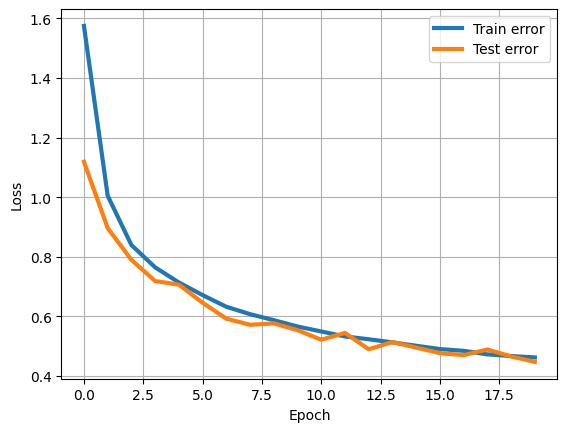

In [7]:
plt.plot(range(20), train_loss_history, '-', linewidth=3, label='Train error')
plt.plot(range(20), test_loss_history, '-', linewidth=3, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [8]:
model = ViT(patch_size=4, num_layers=6, num_heads=4).to(device)
model.load_state_dict(torch.load('vit_model_20_epochs.pth'))


<All keys matched successfully>

In [9]:
for epoch in range(20, 25):
    train_loss = 0.0 # Reset training loss for the new epoch.
    test_loss = 0.0 # Reset test loss for the new epoch.

    # Set the model to training mode.
    model.train()
    for i, data in enumerate(train_data_loader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predicted_output = model(images)
        fit = loss_function(predicted_output, labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item() # Accumulate the batch loss into total training loss.

    model.eval()
    for i, data in enumerate(test_data_loader):
        with torch.no_grad():
            images, labels = data # Disable gradient computation.
            # Move images to computation device.
            images = images.to(device)
            labels = labels.to(device)

            predicted_output = model(images)
            fit = loss_function(predicted_output, labels)
            test_loss += fit.item()

    # Calculate and print the average losses for this epoch.
    train_loss = train_loss / len(train_data_loader)
    test_loss = test_loss / len(test_data_loader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    print(f'Epoch {epoch} Train loss {train_loss} Test loss {test_loss}')


Epoch 20 Train loss 0.4353483517541052 Test loss 0.447522298165947
Epoch 21 Train loss 0.43717684518935074 Test loss 0.447522298165947
Epoch 22 Train loss 0.43705126690839147 Test loss 0.447522298165947
Epoch 23 Train loss 0.43588776991311423 Test loss 0.447522298165947
Epoch 24 Train loss 0.43589898859704734 Test loss 0.447522298165947


In [10]:
torch.save(model.state_dict(), 'vit_model_25_epochs.pth')


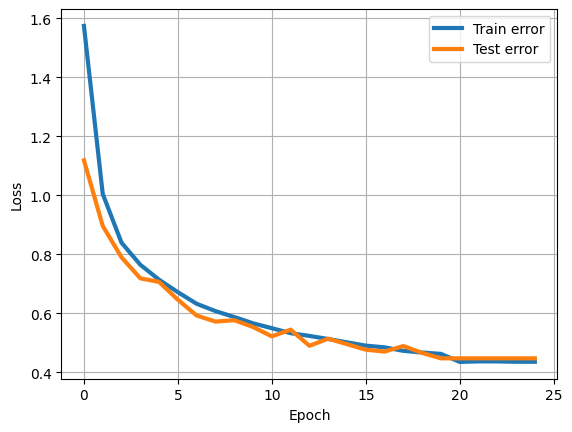

In [11]:
plt.plot(range(25), train_loss_history, '-', linewidth=3, label='Train error')
plt.plot(range(25), test_loss_history, '-', linewidth=3, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


0.1.3 Assessing Model Performance and Visualizing Predictions.

This segment describes the model's accuracy assessment on the test dataset after 25 epochs of training, indicating a reasonable performance range of 83% to 84%. In addition, the section includes visual representations of predictions for three randomly selected samples from the test set. These visualizations include the original image, the actual label, and a bar chart showing the probabilities of predicted classes. The class with the greatest probability is designated as the predicted class.

In [12]:
correct_predictions = 0
total_samples = 0

# Set the model to evaluation mode to turn off dropout and batch normalization.
model.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        # Move images to the computation device.
        images = images.to(device)
        labels = labels.to(device)

        predicted_output = model(images)
        _, predicted_classes = torch.max(predicted_output, 1)
        # Increment the total number of samples evaluated and the number of correct predictions.
        total_samples += labels.size(0)
        correct_predictions += (predicted_classes == labels).sum().item()

# Calculate the accuracy as the number of correct predictions divided by the total number of samples.
test_accuracy = correct_predictions / total_samples
# Print the test accuracy as a percentage with two decimal places.
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 83.97%


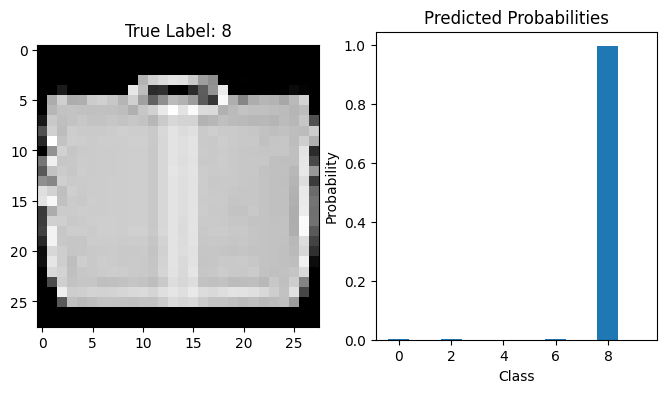

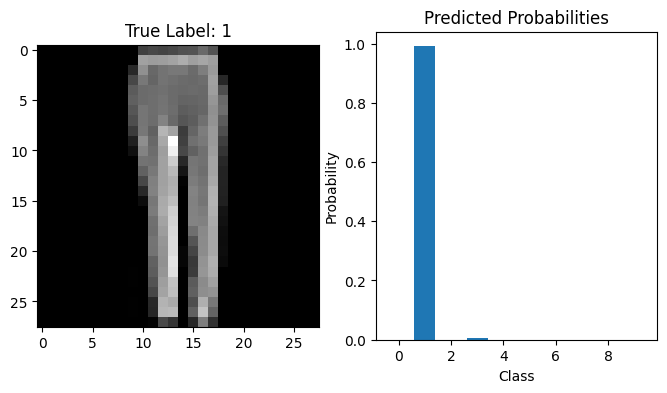

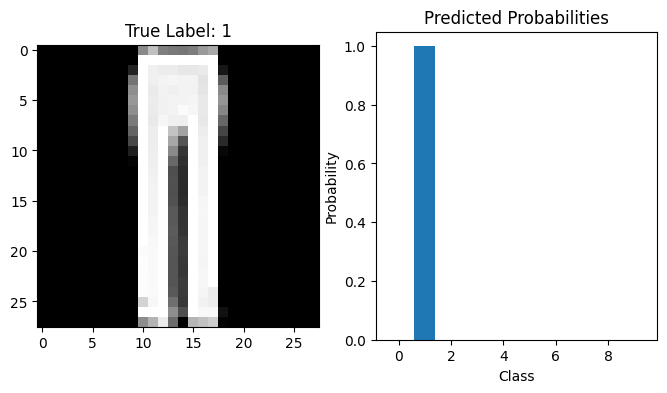

In [13]:
import random

num_samples_to_visualize = 3
random_indices = random.sample(range(len(test_data)), num_samples_to_visualize)
images_to_visualize = []
labels_to_visualize = []

# Retrieve and prepare the images and labels for visualization.
for i in random_indices:
    image, label = test_data[i]
    images_to_visualize.append(image.unsqueeze(0))
    labels_to_visualize.append(label)  # Add batch dimension

# Combine individual images into a batch and move to the computation device.
images_to_visualize = torch.cat(images_to_visualize, dim=0).to(device)
labels_to_visualize = torch.tensor(labels_to_visualize).to(device)

# Make predictions with the model and apply softmax to get probabilities.
predicted_probabilities = torch.nn.functional.softmax(model(images_to_visualize), dim=1)

# Plot each image with its predicted probabilities.
for i in range(num_samples_to_visualize):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(images_to_visualize[i].squeeze().cpu(), cmap=plt.cm.gray)
    plt.title(f'True Label: {labels_to_visualize[i]}')
    plt.subplot(1, 2, 2)
    plt.bar(range(10), predicted_probabilities[i].detach().cpu().numpy())
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Predicted Probabilities')
    plt.show()
